# User Story

Requirements from Bernd Schürenberg:

* Running Mean for MTR 2020 and 2022, 3 weks each
* 8 hours plots of the above

### Ideas / Todo

* add latch valve status 
* plot with matplotlib instead, or seaborn?
   * then save_fig

## Remarks

* Headings with (*) contain re-usable functions

# Imports and dicts (*)

In [1]:
#%matplotlib inline

In [2]:
import pandas as pd
print(pd.__version__)

1.5.3


In [3]:
from collections import defaultdict

In [4]:
from datetime import timedelta

### Dicts

In [5]:
df_i= defaultdict(dict)
df_o = defaultdict()

In [6]:
MTR_weeks = {}

In [7]:
MTR_start = defaultdict()
MTR_stop = defaultdict()

In [8]:
sel = defaultdict()

# Configuration

## User Settings

### Sampling for rolling Mean

* Define the rolling mean area in minutes: e.g. rolling_mean_in_minutes = 5
* It e.g. the sampling rate is 40 sec, i will use the largest multiple of 40 <= rolling_mean_in_minutes
* Must be grate than 1 !

In [9]:
rolling_mean_in_minutes = 4

In [10]:
if rolling_mean_in_minutes < 2:
    exit()

### Sub Plots duration in hours. Must be a devider of 24 hours!

In [11]:
hours = 8

In [12]:
# time frames selected by BS for 8 hour fine plots

sel[2020] = [1,2,6,7,8,]
sel[2022] = [0,1,2,3,6,7,9,10]
#sel[2023] = []

### Plot & Debug (*)

In [13]:
date_col = "date"

In [14]:
# plot size in inches x * y
xs = 10
ys = 10

In [15]:
# Show intermediate Plots and Check Data
debug: bool = False

### DATA: Years and Weeks for week in MTR_weeks[year]

In [16]:
MTR_weeks[2020] = (
    24,
    25,
    26,
)

In [17]:
MTR_weeks[2022] = (
    19,
    20,
    21,
)

In [18]:
"""
MTR_weeks[2023] = (
    20,
    21,
    22,
)
"""

'\nMTR_weeks[2023] = (\n    20,\n    21,\n    22,\n)\n'

## Constants

### Derived from USER input above (*)

In [19]:
figsize = (xs, ys)

### Strings

In [20]:
PT = ['PT 01 (A9901)', 'PT 02 (A9902)', 'PT 03 (A9903)',]
MEAN = ['PT01_mean', 'PT02_mean', 'PT03_mean',]

TM_DICT = dict(zip(PT, MEAN))

### Path and files

In [21]:
DIR: str = "data"
TM: str = "TankAllPressureFine"
KW: str ="kw"
SUF: str = "png.csv"

In [22]:
OUT_DIR: str = "output"
MEAN: str = "mean"
UNIT: str = "sec"
OSUF: str = "csv"

# Functions

## Generators (*)

In [23]:
def gen_keys(my_dict):
    for key in my_dict:
        yield key

In [24]:
def gen_keys_of_keys(my_dict):
    for k1 in gen_keys(my_dict):
        for k2 in gen_keys(my_dict[k1]):
            yield k1, k2

In [25]:
def gen_time_period(start, stop, delta_hours):
    t1 = start
    t2 = t1 + timedelta(hours=delta_hours)
    
    while t2 <= stop:
        yield t1, t2
        
        #time_period_generator.close()
        t1 = t2
        t2 = t1 + timedelta(hours=delta_hours)

In [26]:
def gen_time_periods(df, delta_hours):
        first = df_first(df)
        last = df_last(df)
    
        for start, stop in gen_time_period(first, last, delta_hours):
            yield start, stop

### Tailored

In [27]:
def gen_time_periods_for_MTR_Week(delta_hours):
    for year in MTR_weeks:
        df = df_i[year][MTR_weeks[year][1]] # The actual MTR week
        for i, (start, stop) in enumerate(gen_time_periods(df, delta_hours)):
            yield year, i, start, stop

## read and write (*)

In [28]:
def read_csv(file_path, parse_dates=[date_col]):
    return pd.read_csv(file_path, parse_dates=parse_dates)

In [29]:
def write_csv(df, csv):    
    df.to_csv(csv)

### Tailored

In [30]:
def read_csv_MTR(year, week):
    
    file_path = f"{DIR}/{TM}_{year}_{KW}{week}.{SUF}"
    print(f"df_i[{year}][{week}] from: {file_path}")
    
    return read_csv(file_path)

In [31]:
def write_csv_MTR(year):
    df = df_o[year]
    
    csv = f"{OUT_DIR}/{year}_{MEAN}_{SEC}_{UNIT}.{OSUF}"
    print(f"write: {csv}")
    
    write_csv(df, csv)

## Validation

In [32]:
def check_heads():
    if not debug:
        return
    for year, week in gen_keys_of_keys(MTR_weeks):
        print(f"df_i[{year}][{week}]:")
        
        print(df_i[year][week].head(1))

In [33]:
def check_dtypes():
    if not debug:
        return
    for year, week in gen_keys_of_keys(MTR_weeks):
        print(f"df_i[{year}][{week}]:")
        
        print(df_i[year][week].dtypes)

## get info from df (*)

In [34]:
def df_first(df):
    return df.iloc[0][date_col]

In [35]:
def df_last(df):
    return df.iloc[-1][date_col]

In [36]:
def get_sampling_rate(df):
    return df[date_col].diff().median().total_seconds()

## Analyse

In [37]:
def update_rolling_mean():

    RM = int(rolling_mean_in_minutes * 60 / get_sampling_rate(df_i[year][week]))
    SEC = RM * 40
    
    return (RM, SEC)

In [38]:
def apply_mean():
    for year in MTR_weeks:
        for tm in TM_DICT:
            df_o[year][TM_DICT[tm]] = df_o[year][tm].rolling(RM).mean()  

## Plot

In [39]:
def plot(df, title=None):
    df.plot(x=date_col, subplots=True, figsize=figsize, title=title)

# READ and CHECK File DATA

## read csv

data from: http://xmm.esoc.esa.int/information/sc_data/Replenishing/

In [40]:
for year, week in gen_keys_of_keys(MTR_weeks):
    df_i[year][week] = read_csv_MTR(year, week)

df_i[2020][24] from: data/TankAllPressureFine_2020_kw24.png.csv
df_i[2020][25] from: data/TankAllPressureFine_2020_kw25.png.csv
df_i[2020][26] from: data/TankAllPressureFine_2020_kw26.png.csv
df_i[2022][19] from: data/TankAllPressureFine_2022_kw19.png.csv
df_i[2022][20] from: data/TankAllPressureFine_2022_kw20.png.csv
df_i[2022][21] from: data/TankAllPressureFine_2022_kw21.png.csv


### IMPORTANT: check if sampling rate is almost identical

In [41]:
for year, week in gen_keys_of_keys(MTR_weeks):
    print(f"{year} {week} Time delta mean [sec]: {get_sampling_rate(df_i[year][week])}")

2020 24 Time delta mean [sec]: 40.0
2020 25 Time delta mean [sec]: 40.0
2020 26 Time delta mean [sec]: 40.0
2022 19 Time delta mean [sec]: 40.0
2022 20 Time delta mean [sec]: 40.0
2022 21 Time delta mean [sec]: 40.0


In [42]:
# use last df for calibration

RM, SEC = update_rolling_mean()

## Check Data

In [43]:
check_heads()

In [44]:
check_dtypes()

### Plot Original Data

In [45]:
year = 2020
week = 25
title = f"XMM MTR {year}, week {week}"

debug and plot(df_i[year][week], title=title)

False

In [46]:
year = 2022
week = 20
title = f"XMM MTR {year}, week {week}"

debug and plot(df_i[year][week], title=title)

False

# Prepare data

### Cobine 3 weeks

In [47]:
for year in MTR_weeks:
    df_o[year] = pd.concat([df_i[year][week] for week in MTR_weeks[year]])

### and check

In [48]:
year=2020
title=f"XMM MTR {year}"

debug and plot(df_o[year], title=title)

False

In [49]:
year=2022
title=f"XMM MTR {year}"

debug and plot(df_o[year], title=title)

False

# Analyse data

## Applying Rolling Mean to PT

In [50]:
apply_mean()  

# OUTPUT

## Save CSV with means

In [51]:
for year in MTR_weeks:
    write_csv_MTR(year)

write: output/2020_mean_240_sec.csv
write: output/2022_mean_240_sec.csv


## Plots

In [52]:
### 3 Week Plots

In [53]:
year = 2020
title = f"XMM MTR {year}, mean {SEC} sec"

debug and plot(df_o[year], title=title)

False

In [54]:
year = 2022
title = f"XMM MTR {year}, mean {SEC} sec"
debug and plot(df_o[year], title=title)

False

### hour plots, see {hour} defenition above

In [55]:
for _, i, start, stop in gen_time_periods_for_MTR_Week(hours):
    
    t1=start.replace(tzinfo=None)
    t2=stop.replace(tzinfo=None)
    
    debug and print(f"{i:02}, {t1}, {t2}")

In [56]:
# Bernd Schürenberg Selection

y=2022
t=9

In [57]:
"""
# for quick tests
rolling_mean_in_minutes = 4
RM, SEC = update_rolling_mean()
apply_mean()  
print(RM, SEC)
"""

'\n# for quick tests\nrolling_mean_in_minutes = 4\nRM, SEC = update_rolling_mean()\napply_mean()  \nprint(RM, SEC)\n'

09, 2022-05-19 00:00:00, 2022-05-19 08:00:00


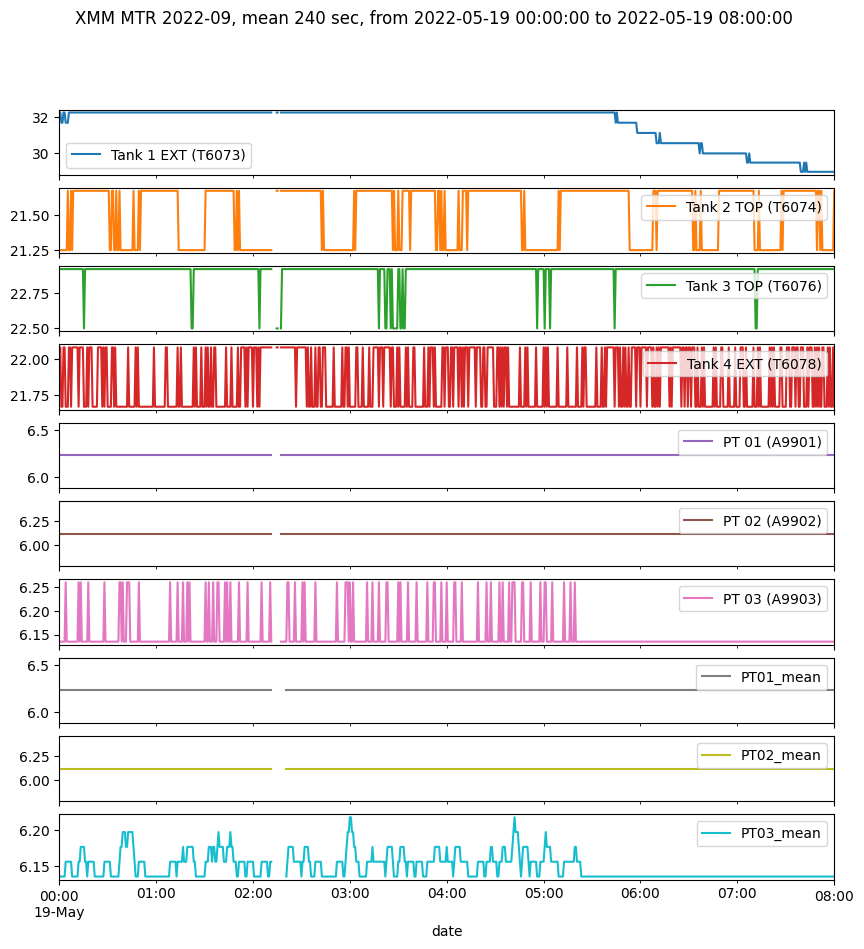

In [58]:
for year, i, start, stop in gen_time_periods_for_MTR_Week(hours):
    
    if year == y and i == t:  # BS Selection
        
        t1=start.replace(tzinfo=None)
        t2=stop.replace(tzinfo=None)
        
        print(f"{i:02}, {t1}, {t2}")
        title=f"XMM MTR {year}-{i:02}, mean {SEC} sec, from {t1} to {t2}"
        
        mask = (
            (df_o[year][date_col] >=start) & 
            (df_o[year][date_col] <= stop)
        )
        
        plot(df_o[year].loc[mask], title=title)
        
        
        

## Save Plots

* plot in new view
  * save as png
  
---

* download local
  * save in git: https://gitlab.com/sc-data/xmm-mtr/-/tree/main